/var/folders/v2/rffc9mbs5q9859rgtz83_1p00000gn/T/ipykernel_64274/4156440405.py:15: RuntimeWarning: divide by zero encountered in true_divide
  r = X[:, i] / X[:, j]
/var/folders/v2/rffc9mbs5q9859rgtz83_1p00000gn/T/ipykernel_64274/4156440405.py:16: RuntimeWarning: divide by zero encountered in true_divide
  r2 = X2[:, i] / X2[:, j]
/var/folders/v2/rffc9mbs5q9859rgtz83_1p00000gn/T/ipykernel_64274/4156440405.py:15: RuntimeWarning: invalid value encountered in true_divide
  r = X[:, i] / X[:, j]
/var/folders/v2/rffc9mbs5q9859rgtz83_1p00000gn/T/ipykernel_64274/4156440405.py:16: RuntimeWarning: invalid value encountered in true_divide
  r2 = X2[:, i] / X2[:, j]


2nd-Order Polynomial: R2 = 0.756990566988826, MSE = 65.75854454948272, R2(aug) = -69.57909457605257, MSE(aug) = 19098.75874953422
Support Vector Regression: R2 = 0.649379953962911, MSE = 94.87806144632846, R2(aug) = 0.7929542613268086, MSE(aug) = 56.02674045042351
Gaussian Process Regression: R2 = 0.8708298190584253, MSE = 34.953553006811546, R2(aug) = 0.9000171106749236, MSE(aug) = 27.05544883752197
Random Forest: R2 = 0.9285498007345793, MSE = 19.33448036664711, R2(aug) = 0.9257283784465502, MSE(aug) = 20.09795946670217
XGBoost: R2 = 0.9367804855575594, MSE = 17.10725055133451, R2(aug) = 0.9375411912741023, MSE(aug) = 16.901402983483


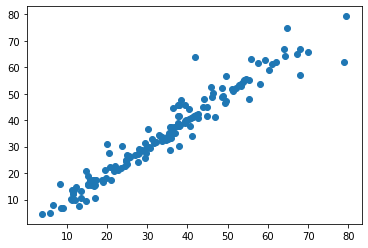

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pandas as pd
import math 


def augment_feature(X, X2):
    X_aug = X.copy()
    X2_aug = X2.copy()
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            if i == j:
                continue
            r = X[:, i] / X[:, j]
            r2 = X2[:, i] / X2[:, j]
            if np.isfinite(r).all() and np.isfinite(r2).all():
                X_aug = np.append(X_aug, r[:, np.newaxis], axis=1)
                X2_aug = np.append(X2_aug, r2[:, np.newaxis], axis=1)
    return X_aug, X2_aug

def GPR(X_train, X_test, y_train, y_test):
    import sklearn.gaussian_process as gp

    kernel = gp.kernels.ConstantKernel(1.0, (1e-5, 1e5)) * gp.kernels.RBF(10.0, (1e-5, 1e5))
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
    model.fit(X_train, y_train)
    params = model.kernel_.get_params()

    y_predicted, std = model.predict(X_test, return_std=True)
    return y_predicted


def NN(X_train, X_test, y_train, y_test):
    import keras

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    model.fit(X_train, y_train, batch_size=128, epochs=1000)

    y_predicted = model.predict(X_test)
    return y_predicted


def polynomial(X_train, X_test, y_train, y_test):
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import make_pipeline

    model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression(fit_intercept=True))
    model = model.fit(X_train, y_train)

    y_predicted = model.predict(X_test)
    return y_predicted


def random_forest(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestRegressor

    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    return y_predicted


def SVR(X_train, X_test, y_train, y_test):
    from sklearn.svm import SVR
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler

    model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.2))
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    return y_predicted


def xgboost(X_train, X_test, y_train, y_test):
    import xgboost

    model = xgboost.XGBRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    return y_predicted


def xgboost_with_tuning(X_train, X_test, y_train, y_test):
    from sklearn.model_selection import GridSearchCV
    import xgboost

    xgb = xgboost.XGBRegressor(random_state=0)
    xgb_parameters = {'n_estimators': [10, 20, 50, 100, 200, 300],
                      'max_depth': [5, 10, 15, 20],
                      'learning_rate': [1e-2, 0.1, 0.2, 0.5, 0.8],
                      }
    xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_parameters, n_jobs=-1)
    xgb_grid_fit = xgb_grid.fit(X_train, y_train)
    model = xgb_grid_fit.best_estimator_
    y_predicted = model.predict(X_test)
    return y_predicted


if __name__ == '__main__':
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.model_selection import train_test_split

    data = pd.read_excel('Concrete_Data.xls')
    X = data.iloc[:,0:8].values
    y = data.iloc[:,8]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
    X_train_aug, X_test_aug = augment_feature(X_train, X_test)

    methods = {
            '2nd-Order Polynomial': polynomial,
            'Support Vector Regression': SVR,
            'Gaussian Process Regression': GPR,
            #'Neural Networks': NN,
            'Random Forest': random_forest,
            'XGBoost': xgboost,
            }

    for name, func in methods.items():
        y_predicted = func(X_train, X_test, y_train, y_test)
        R2 = r2_score(y_test, y_predicted)
        MSE = mean_squared_error(y_test, y_predicted)

        y_aug_predicted = func(X_train_aug, X_test_aug, y_train, y_test)
        R2_aug = r2_score(y_test, y_aug_predicted)
        MSE_aug = mean_squared_error(y_test, y_aug_predicted)

        print('{}: R2 = {}, MSE = {}, R2(aug) = {}, MSE(aug) = {}'
                .format(name, R2, MSE, R2_aug, MSE_aug))

    import matplotlib.pyplot as plt
    plt.scatter(y_predicted, y_test)
    plt.show()

In [3]:
import shap

#First Major Implementation
from sklearn.ensemble import RandomForestRegressor
def model2(X,y):
    xaug, xtaug = augment_feature(X_train, X_test)
    rbf = RandomForestRegressor()
    rr = rbf.fit(xaug, y_train)
   # data_asframe =  pd.DataFrame(rbf)
   # return rbf.predict(data_asframe)
    return rr

ren = model2(X_train, y_train)
    
#ren.predict(X_test)
    
explainer = shap.Explainer(ren, X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

#Second Major Implementation
from sklearn.ensemble import RandomForestRegressor
def model2(X,y):
    xaug, xtaug = augment_feature(X_train, X_test)
    rbf = RandomForestRegressor()
    rr = rbf.fit(xaug, y_train)
   # data_asframe =  pd.DataFrame(rbf)
   # return rbf.predict(data_asframe)
    return rr

ren = model2(X_train, y_train)
    
explainer = shap.Explainer(ren, X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

divide by zero encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


Exception: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 49.688499, while the model output was 18.245260. If this difference is acceptable you can set check_additivity=False to disable this check.